In [1]:
import confirm.outlaw.nb_util as nb_util
nb_util.setup_nb()

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
# Run on CPU because a concurrent process is probably running on GPU.
jax.config.update('jax_platform_name', 'cpu')

import confirm.mini_imprint.lewis_drivers as lts
from confirm.lewislib import lewis

from adastate import load_iter, AdaParams

In [2]:
name = '4d_full'
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)

In [3]:
# Configuration used during simulation
# TODO: things that should be saved in the future!!

adap = AdaParams(
    init_K = 1000,
    n_sim_double = 8,
    alpha_target = 0.025,
    grid_target = 0.002,
    bias_target = 0.002
)
(
    g,
    sim_sizes,
    bootstrap_cvs,
    typeI_sum,
    hob_upper,
    pointwise_target_alpha,
), _, _ = load_iter(name, 'latest')

loading checkpoint 4d_full/1980.pkl


In [4]:
overall_cv = np.min(bootstrap_cvs[:, 0])
twb_min_cv = bootstrap_cvs[:, -2]
twb_mean_cv = bootstrap_cvs[:, -1]
inflated_min_cv = twb_mean_cv + (twb_min_cv - twb_mean_cv) * 6

B_lamss_idx = bootstrap_cvs[:, 1:-2].argmin(axis=0)
B_lamss = bootstrap_cvs[B_lamss_idx, np.arange(1, 1 + bootstrap_cvs.shape[1] - 3)]
twb_B_lamss = inflated_min_cv[B_lamss_idx]
B_min = bootstrap_cvs[:, 1:-2].min(axis=1)

In [5]:
print('overall_cv', overall_cv)
print('bias driver priority', np.sum(inflated_min_cv[:, None] < twb_B_lamss[None, :], axis=0))
bias_bad = B_min < overall_cv
print('n bias bad', np.sum(bias_bad))
for i in range(10):
    inflated_min_cv = twb_mean_cv + (twb_min_cv - twb_mean_cv) * i
    dangerous = np.sum(inflated_min_cv[bias_bad] < overall_cv)
    collateral = np.sum(inflated_min_cv < overall_cv)
    print(f'inflation factor {i}')
    print(f'    dangerous tiles caught: {dangerous}')
    print(f'    collateral tiles caught: {collateral}')

print('lambda**B', B_lamss)
total_effort = np.sum(sim_sizes)
for K in np.unique(sim_sizes):
    sel = sim_sizes == K
    count = np.sum(sel)
    print(f"K={K}:")
    print(f'    count={count / 1e6:.3f}m')
    print(f'    lambda**B[K]={bootstrap_cvs[sel, 1:-2].min(axis=0)}')
    print(f'    min lambda*B[K]={np.min(B_min[sel]):.4f}')
    print(f'    min lambda*b[K]={np.min(bootstrap_cvs[sel, -2]):.4f}')
    effort = K * count / total_effort
    print(f'    % effort={100 * effort:.4f}') 

overall_cv 0.042493794574925796
bias driver priority [3455879  342455  342455   66038  567953  342455  726208  386529   66038  386529 1034003  386529
  111265  111265 2197487  265523   66038  237095  591178  111265  342455  342455  295350   66038
   70084   39814  342455  775739  342455   66038  591178  143731  342455   66038  567953  307515
  567953  342455  567953  386529  328055   66038   66038  342455  101815   70084  342455  726208
  567953  473636]
n bias bad 1947679
inflation factor 0
    dangerous tiles caught: 2684
    collateral tiles caught: 2684
inflation factor 1
    dangerous tiles caught: 1890891
    collateral tiles caught: 1993207
inflation factor 2
    dangerous tiles caught: 1945561
    collateral tiles caught: 2756687
inflation factor 3
    dangerous tiles caught: 1947080
    collateral tiles caught: 3328606
inflation factor 4
    dangerous tiles caught: 1947437
    collateral tiles caught: 3474646
inflation factor 5
    dangerous tiles caught: 1947549
    collatera

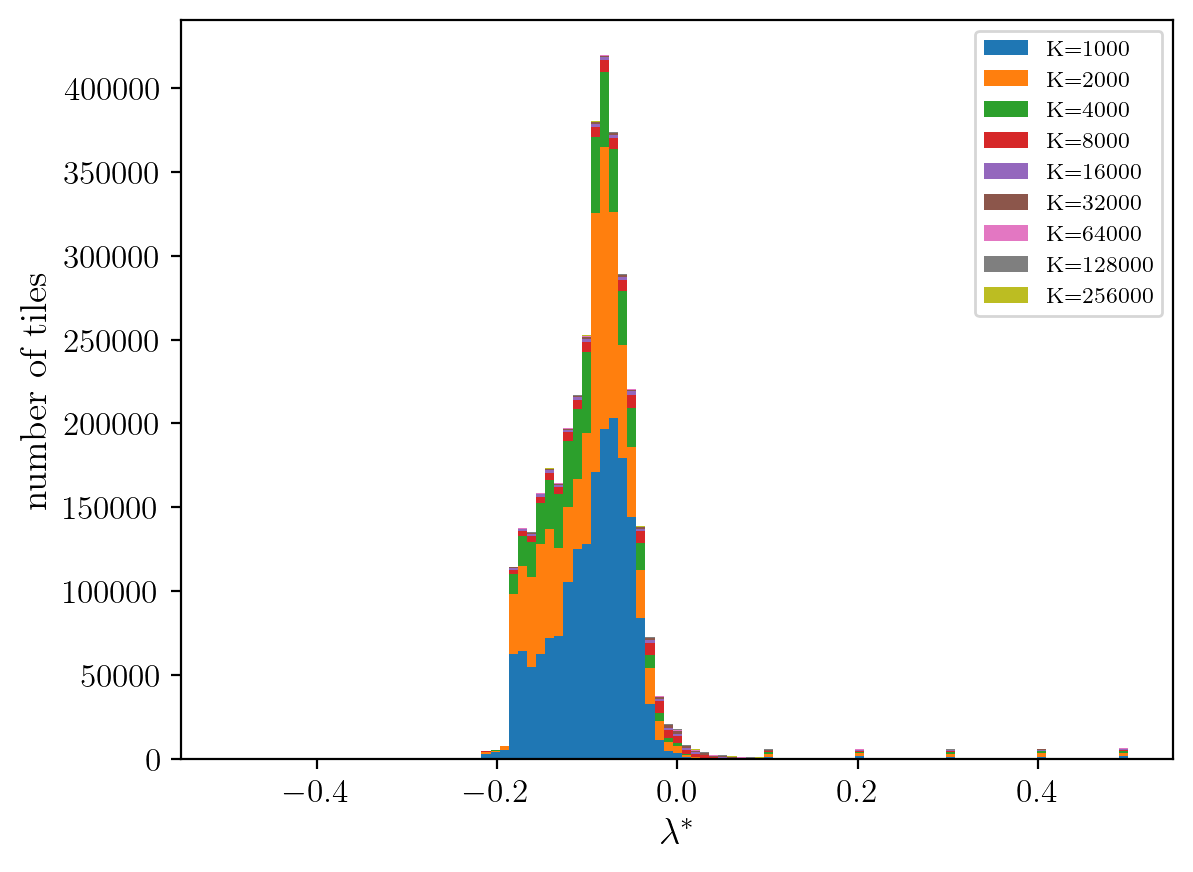

In [9]:
from diagnostics import status_report, lamstar_histogram

tilewise_bootstrap_min_cv = bootstrap_cvs[:, -2]
tilewise_bootstrap_mean_cv = bootstrap_cvs[:, -1]
inflated_min_cv = tilewise_bootstrap_mean_cv + (tilewise_bootstrap_min_cv - tilewise_bootstrap_mean_cv) * 6
lamstar_histogram(inflated_min_cv, sim_sizes, xlim=[-0.5, 0.5])
plt.show()

overall_cv: 0.0425
number of tiles near critical: 1177846
    and with loose bounds 509373
sim size distribution: 
{   1000: 2385765,
    2000: 1193954,
    4000: 568893,
    8000: 193455,
    16000: 91375,
    32000: 48521,
    64000: 27274,
    128000: 15859,
    256000: 10735}
sim size effort %: 
{   1000: 13.155434416098414,
    2000: 13.167251211111205,
    4000: 12.547815147388738,
    8000: 8.53389856910909,
    16000: 8.061667899535738,
    32000: 8.561645705135398,
    64000: 9.625124171466492,
    128000: 11.193432883719815,
    256000: 15.15372999643511}


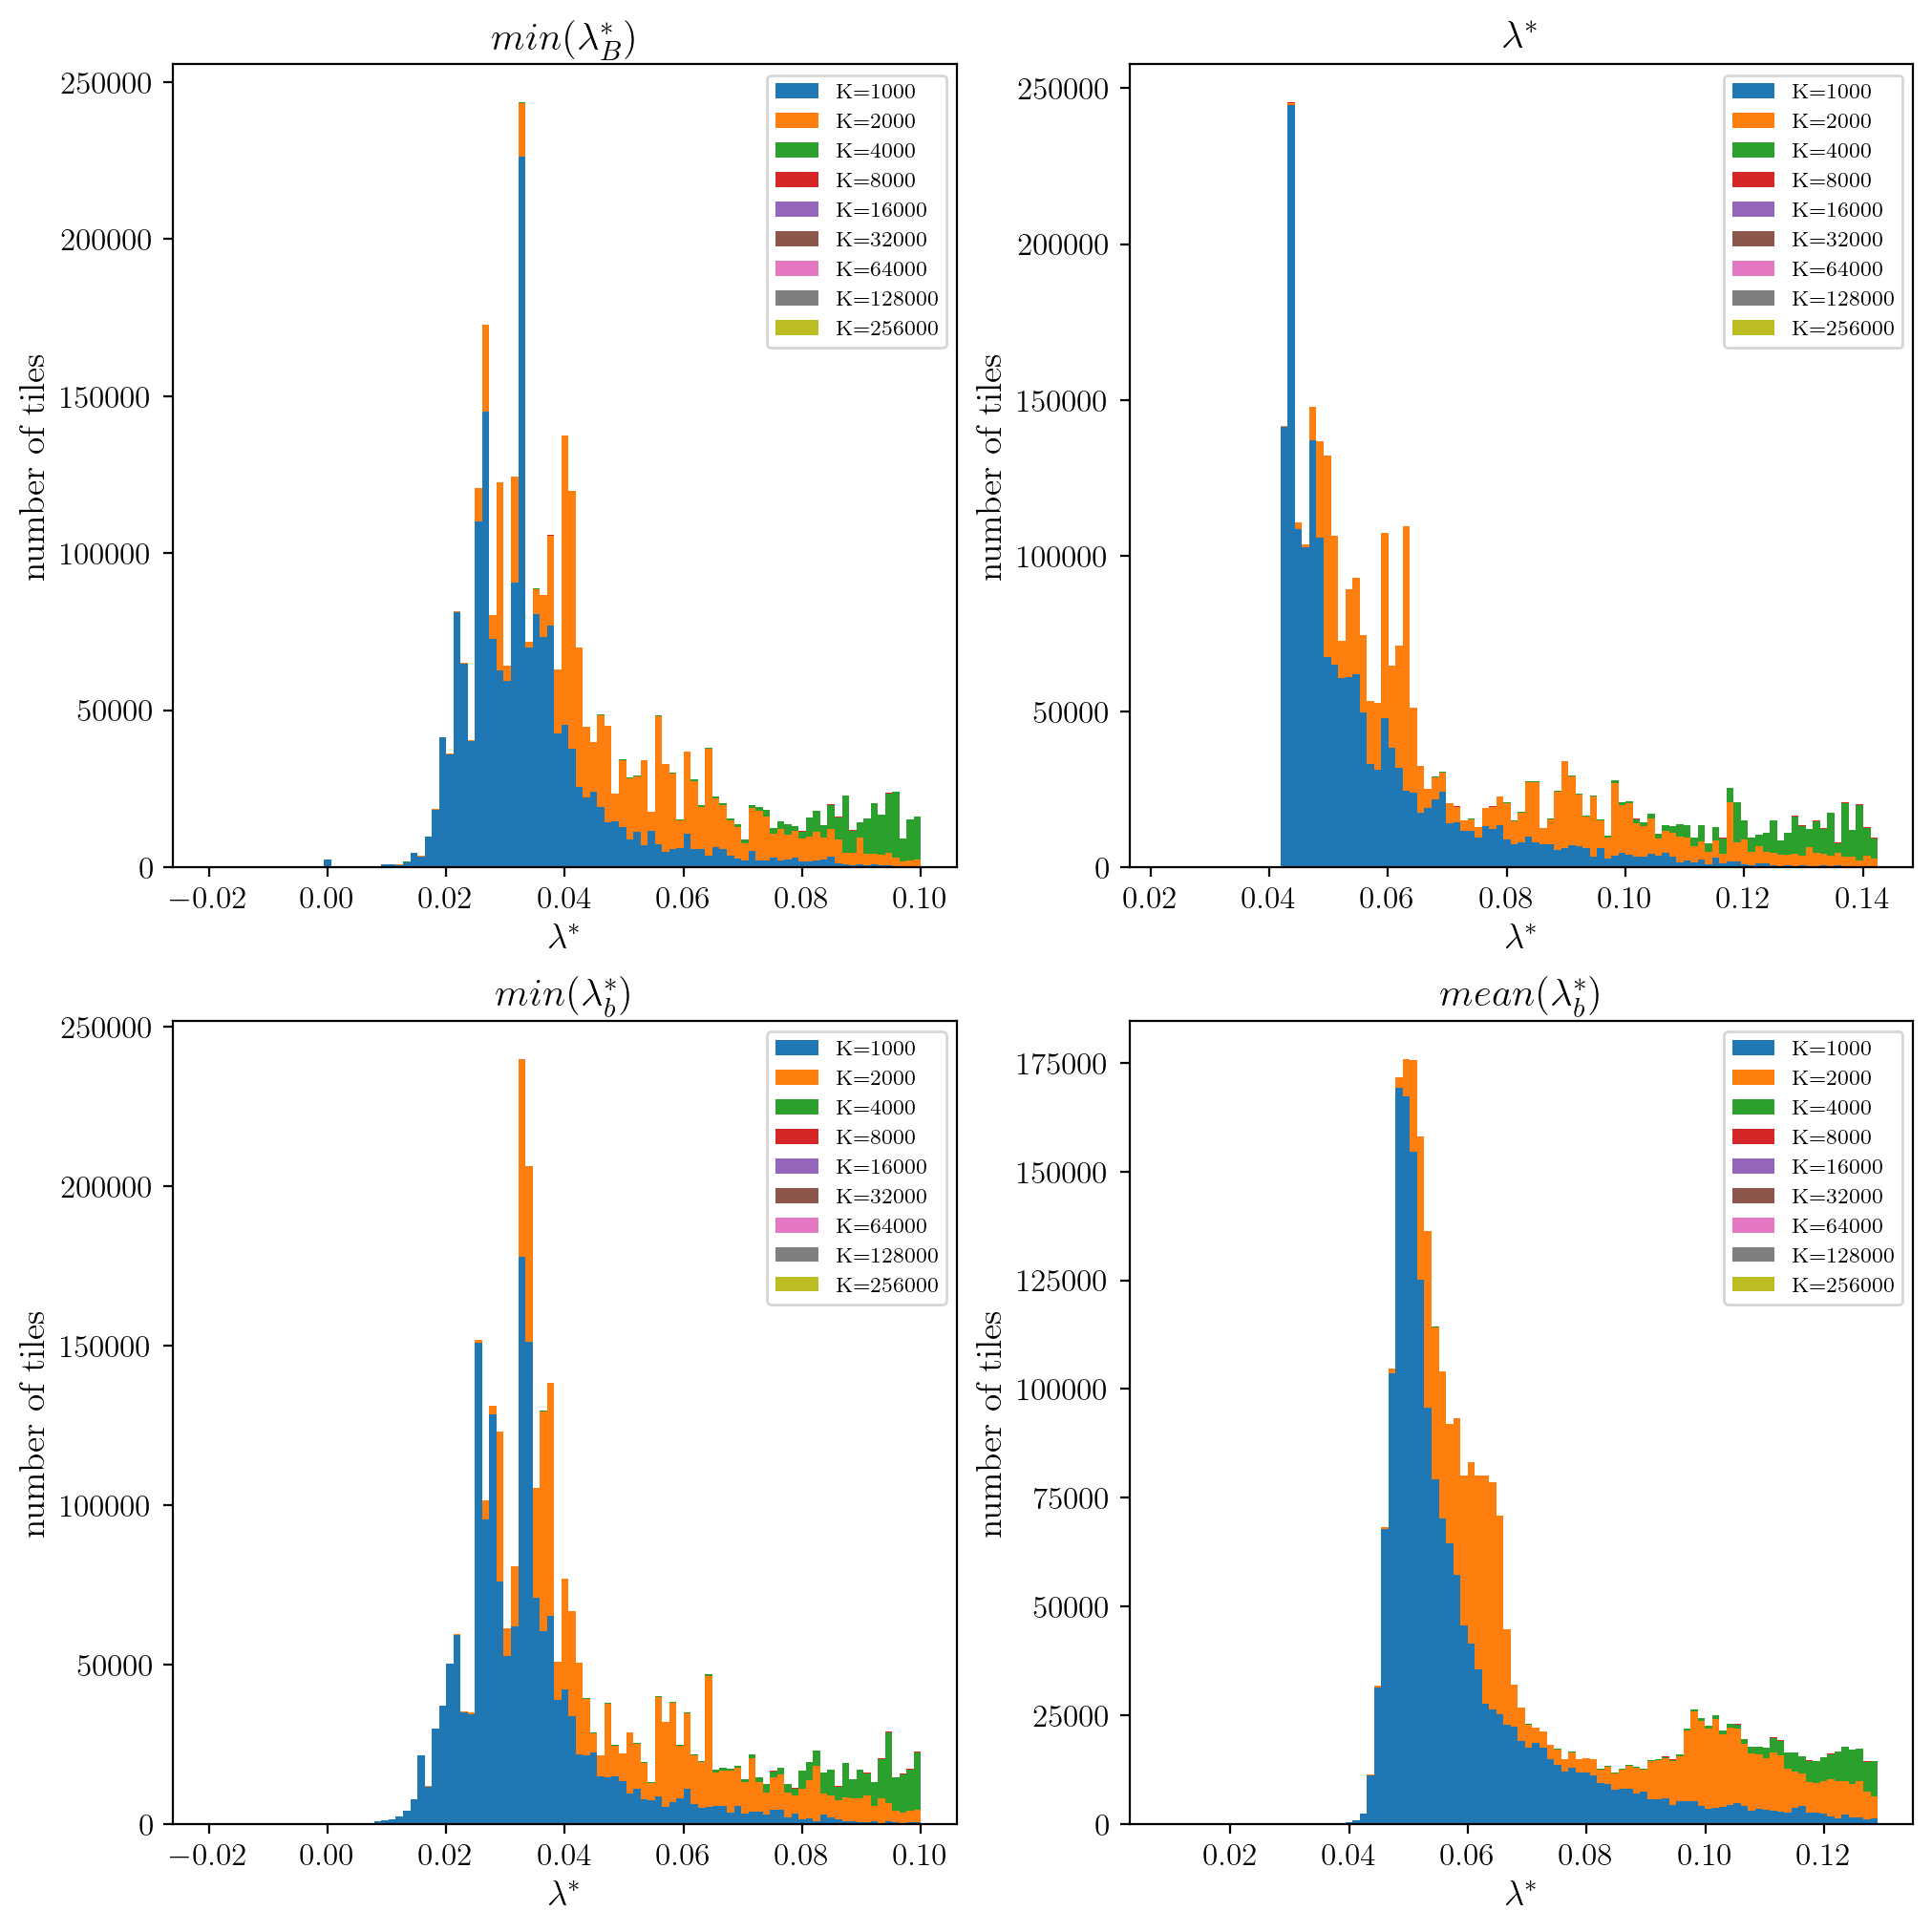

In [7]:

rpt = status_report(adap, sim_sizes, bootstrap_cvs, pointwise_target_alpha)
print(rpt)
plt.figure(figsize=(10, 10), constrained_layout=True)
plt.subplot(2,2, 1)
plt.title('$min(\lambda^*_B)$')
lamstar_histogram(bootstrap_cvs[:, 1:-2].min(axis=1), sim_sizes)
for i, (idx, title) in enumerate([(0, '$\lambda^{*}$'), (-2, '$min(\lambda^*_b)$'), (-1, '$mean(\lambda^*_b)$')]):
    plt.subplot(2,2,i + 2)
    plt.title(title)
    lamstar_histogram(bootstrap_cvs[:, idx], sim_sizes)
plt.show()

## Resimulation

In [9]:
import pandas as pd
friends = np.where(bootstrap_cvs[:,0] < 0.045)[0]
print(pd.DataFrame(sim_sizes[friends]).describe())
print(pd.DataFrame(pointwise_target_alpha[friends]).describe())

                  0
count  34476.000000
mean    1160.053370
std      564.423262
min     1000.000000
25%     1000.000000
50%     1000.000000
75%     1000.000000
max     8000.000000
                  0
count  34476.000000
mean       0.006419
std        0.002901
min        0.000561
25%        0.004503
50%        0.004715
75%        0.010948
max        0.011460


In [10]:
seed = 0
src_key = jax.random.PRNGKey(seed)
key1, key2, key3 = jax.random.split(src_key, 3)

unifs = jax.random.uniform(key=key1, shape=(adap.max_sim_size,) + lei_obj.unifs_shape(), dtype=jnp.float32)
unifs_order = jnp.arange(0, unifs.shape[1])
nB_global = 30
nB_tile = 40
bootstrap_idxs = {
    K: jnp.concatenate((
        jnp.arange(K)[None, :],
        jax.random.choice(key2, K, shape=(nB_global, K), replace=True),
        jax.random.choice(key3, K, shape=(nB_tile, K), replace=True)
    )).astype(jnp.int32)
    for K in (adap.init_K * 2 ** np.arange(0, adap.n_sim_double + 1))
}

In [11]:
print('hi')

hi


In [12]:
which = friends[:4]
lamstar = lts.bootstrap_tune_runner(
    lei_obj,
    sim_sizes[which],
    pointwise_target_alpha[which],
    g.theta_tiles[which],
    g.null_truth[which],
    unifs,
    bootstrap_idxs,
    unifs_order,
    grid_batch_size=4
)

tuning for 1000 simulations with 3 tiles and batch size (4, 1000)


In [13]:
stats = np.random.rand(3, 1000)

In [38]:
from confirm.lewislib import batch
grid_batch_size=4
def printer(x, y, z):
    print(x.shape, y.shape, z.shape)
    return 0
tunev = jax.jit(jax.vmap(jax.vmap(lts.tune, in_axes=(None, 0, None)), in_axes=(0, None, 0)))
batched_tune = batch.batch(
    batch.batch(tunev, 10, in_axes=(None, 0, None), out_axes=(1,)),
    grid_batch_size, in_axes=(0, None, 0)
)
batched_tune(stats, bootstrap_idxs[1000], np.array([0.025, 0.025, 0.025])).shape

(3, 71)

In [31]:
bootstrap_idxs[1000].shape

(71, 1000)

In [28]:
batch.batch(lts.tunev, 10, in_axes=(None, 0, None))(stats[0], bootstrap_idxs[1000], 0.025).shape

(71,)

In [36]:
tunev(stats, bootstrap_idxs[1000], np.full(3, 0.025)).shape

(3, 71)

In [23]:
bootstrap_idxs[1000].shape

(71, 1000)

## Look at the worst case from bootstrap group 1.

- $\lambda^*$ is the tile-wise threshold
- $\lambda^{**}$ is the global minimum threshold.
-

- TODO: what is the right notation for the different $\lambda$??

These are points that will drive down $\lambda^*_B$

In [4]:
bootstrap_mins2 = bootstrap_cvs[:,1:-2].min(axis=1)
trixy = np.argsort(bootstrap_mins2)[:100]
print(bootstrap_mins2[trixy])
print(bootstrap_cvs[trixy, 0])
print(bootstrap_cvs[trixy, -2])
print(bootstrap_cvs[trixy, -1])

[0.         0.         0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.00514508
 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508
 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508
 0.00514508 0.00514508 0.00514508 0.00514508 0.00514508 0.00859748 0.00859748 0.01154261 0.01154261
 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261
 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261 0.01154261
 0.01154261 0.01154261 0.0115426

In [5]:
trixy = bootstrap_cvs[:, :-2].argmin(axis=0)
print(bootstrap_mins2[trixy])
print(bootstrap_cvs[trixy, 0])
print(bootstrap_cvs[trixy, -2])
print(bootstrap_cvs[trixy, -1])

[0.04354637 0.04354637 0.02789495 0.01429929 0.0269085  0.00859748 0.         0.04354637 0.02218252
 0.0393493  0.        ]
[0.04354637 0.04354637 0.08347789 0.12302681 0.07766329 0.11524351 0.10524046 0.04354637 0.20173591
 0.07177567 0.08327259]
[0.04354637 0.04354637 0.06162066 0.0683219  0.05937429 0.05981035 0.06252524 0.04354637 0.07761585
 0.0587158  0.05974139]
[0.04354637 0.04354637 0.09433731 0.11718224 0.07398375 0.23521529 0.1059908  0.04354637 0.22964628
 0.07535339 0.12694353]


In [6]:
pointwise_target_alpha[trixy], sim_sizes[trixy], g.radii[g.grid_pt_idx[trixy]]

(array([0.02050906, 0.02050906, 0.01170158, 0.00495953, 0.01116916, 0.00455338, 0.00462812,
        0.02050906, 0.00494191, 0.01693105, 0.00451102]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]),
 array([[0.00390625, 0.00390625, 0.00390625, 0.00390625],
        [0.00390625, 0.00390625, 0.00390625, 0.00390625],
        [0.015625  , 0.015625  , 0.015625  , 0.015625  ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.015625  , 0.015625  , 0.015625  , 0.015625  ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.00390625, 0.00390625, 0.00390625, 0.00390625],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ],
        [0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ],
        [0.03125   , 0.03125   , 0.03125   , 0.03125   ]]))

In [12]:
import scipy.spatial
tree = scipy.spatial.KDTree(g.theta_tiles)

In [14]:
worst_tile_idx = np.argmin(bootstrap_cvs[:,0])
worst_tile = g.theta_tiles[worst_tile_idx]

slice_pt = worst_tile
plot_dims = [0, 1]
unplot_dims = list(set(range(g.d)) - set(plot_dims))

slicex = [-1, 1]
slicey = [-1, 1]
nx = ny = 100
xvs = np.linspace(*slicex, nx)
yvs = np.linspace(*slicey, ny)
grid = np.stack(np.meshgrid(xvs, yvs, indexing='ij'), axis=-1)
full_grid = np.empty((nx * ny, g.d))
full_grid[:, plot_dims] = grid.reshape(-1, 2)
full_grid[:, unplot_dims] = slice_pt[unplot_dims]

In [20]:
closest_idx[1]

array([ 127690,  127687,  127687,  127687,  127687,  127687,  127687,  127687,  127686,  127686,
       ...,   27258,   27258,   27258, 1102285, 1102285, 1102281,  308063, 3362909, 3362909,
       3382399])

In [15]:
closest_idx = tree.query(full_grid)
closest_idx

(array([0.87117257, 0.85748238, 0.84260622, 0.82795573, 0.81354311, 0.79938122, 0.78548363,
        0.7718646 , 0.75713012, 0.74239052, ..., 0.04222419, 0.03402861, 0.03673218, 0.02316994,
        0.02160324, 0.02009795, 0.02419237, 0.01947861, 0.01010055, 0.01235265]),
 array([ 127690,  127687,  127687,  127687,  127687,  127687,  127687,  127687,  127686,  127686,
        ...,   27258,   27258,   27258, 1102285, 1102285, 1102281,  308063, 3362909, 3362909,
        3382399]))

In [ ]:
eval_pts = 

20105


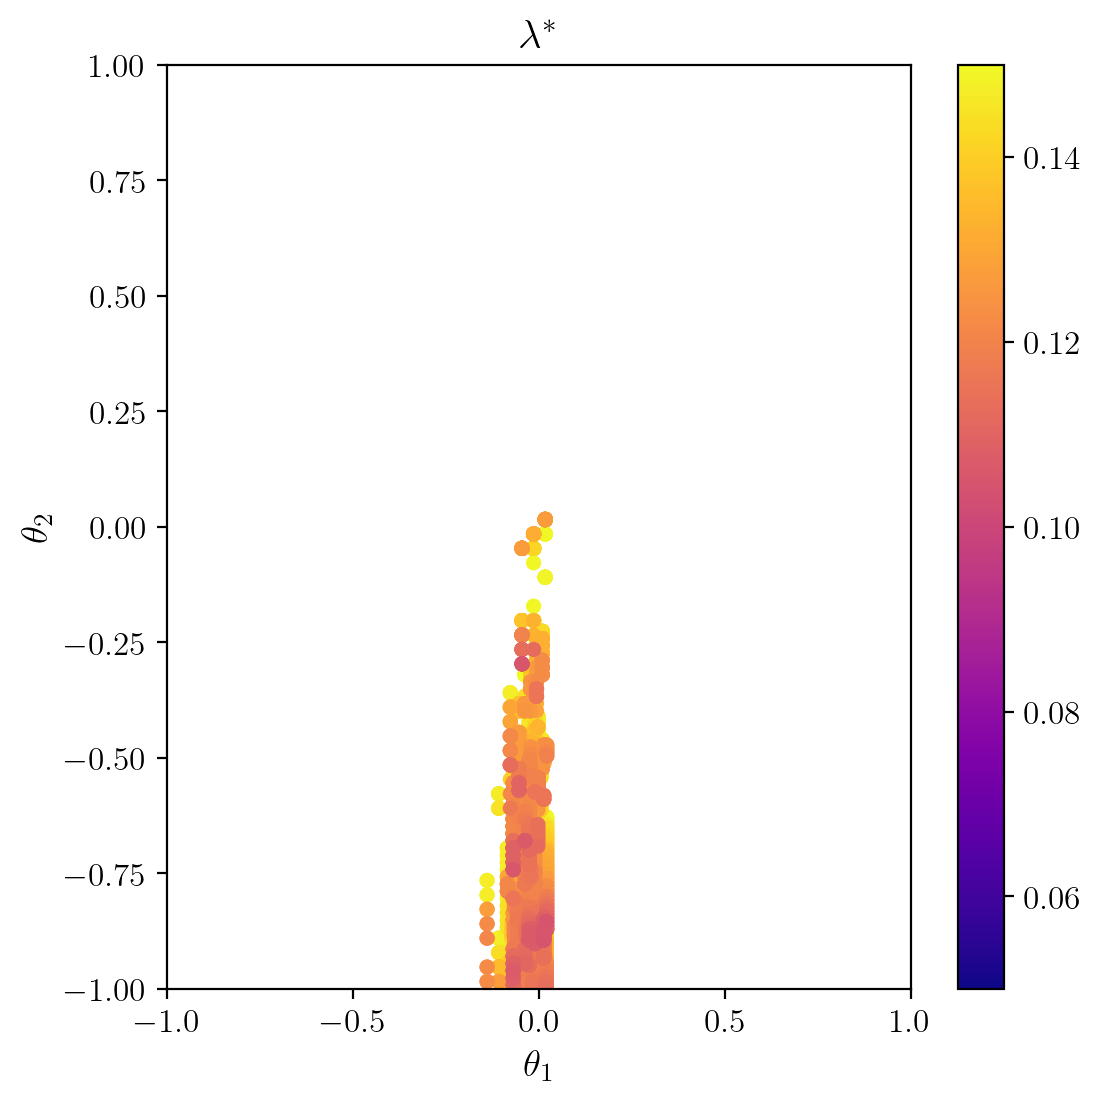

20282


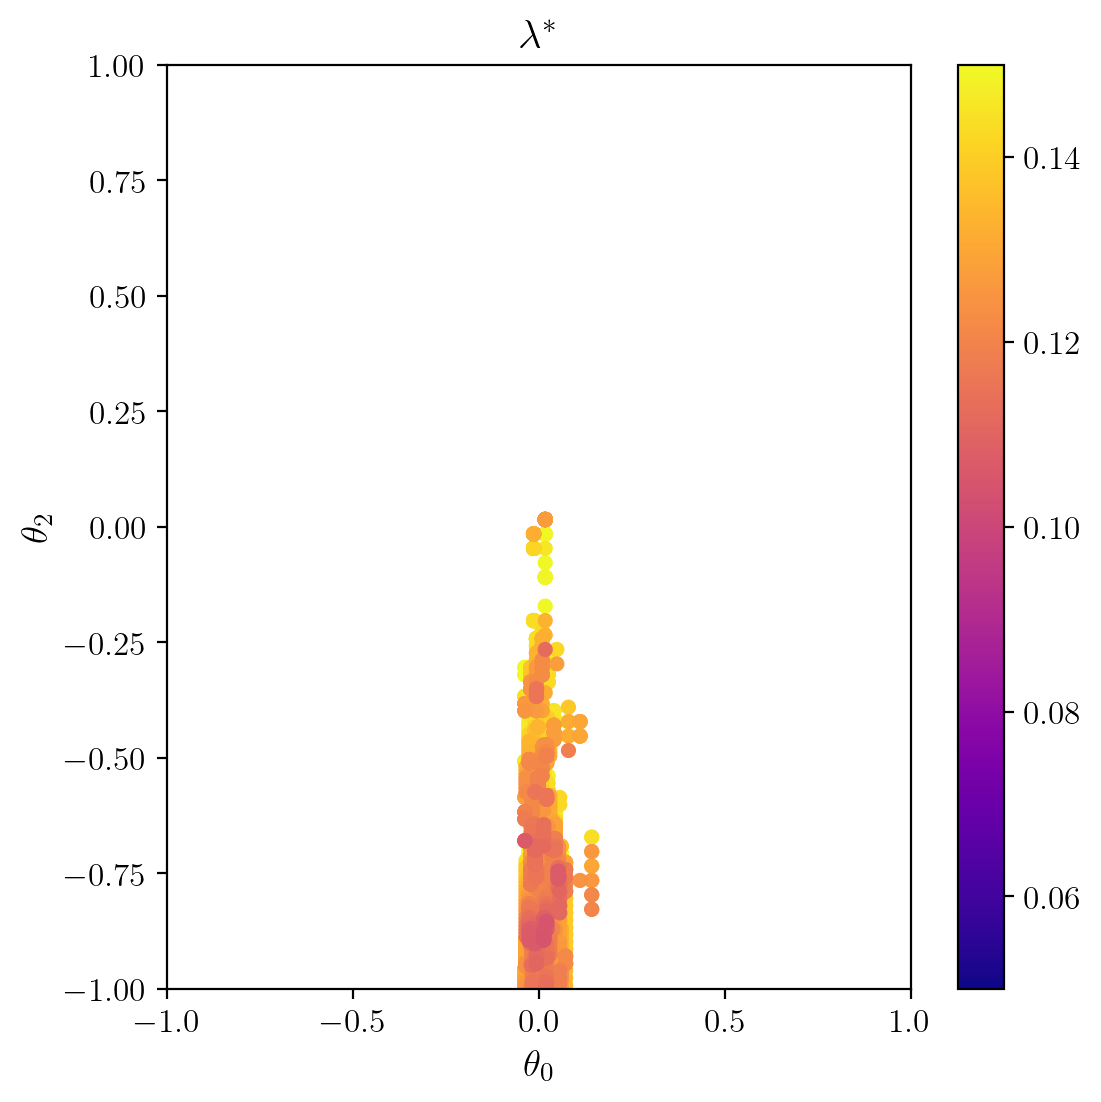

In [11]:
# worst_tile_idx = np.argmin(bootstrap_cvs[:,0])
# worst_tile = g.theta_tiles[worst_tile_idx]
# # def pandemonium(field):
# field = bootstrap_cvs[:,0]
# # for unplot_set in [{0, 1}, {1, 2}]:
# for unplot_set in [{0}, {1}]:
#     plot = list(set(range(n_arms)) - unplot_set)
#     unplot = list(unplot_set)
#     axis_slice = np.all(np.abs(g.theta_tiles[:, unplot] - (-0.01)) < 0.03, axis=-1)
#     select = np.where(axis_slice & (field < 0.15))[0]

#     ordered_select = select[np.argsort(field[select])[::-1]]
#     print(ordered_select.shape[0])

#     plt.figure(figsize=(6, 6))
#     plt.title(r"$\lambda^{*}$")
#     plt.scatter(
#         g.theta_tiles[ordered_select, plot[0]],
#         g.theta_tiles[ordered_select, plot[1]],
#         c=field[ordered_select],
#         vmin=0.05,
#         vmax=0.15,
#         s=20,
#     )
#     plt.xlim([-1, 1])
#     plt.ylim([-1, 1])
#     plt.colorbar()
#     plt.xlabel(f"$\\theta_{plot[0]}$")
#     plt.ylabel(f"$\\theta_{plot[1]}$")
#     plt.show()